In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import os
from PIL import Image
import time

In [15]:
class ModifiedCheXNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedCheXNet, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [17]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of classes
num_classes = 2

# Set the paths and filenames
data_csv_file = 'sample_labels.csv'
data_dir = 'images/'

In [18]:
# Set the batch size and number of epochs
batch_size = 32
num_epochs = 10


In [19]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
# Create the dataset
dataset = CustomDataset(data_csv_file, data_dir, transform=transform)

In [26]:

# Split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Create the model
model = ModifiedCheXNet(num_classes)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
avg_losses =[]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    avg_losses.append(train_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1/10, Train Loss: 0.6529, Accuracy: 63.18%
Epoch 2/10, Train Loss: 0.6333, Accuracy: 66.17%
Epoch 3/10, Train Loss: 0.6182, Accuracy: 66.84%
Epoch 4/10, Train Loss: 0.6094, Accuracy: 67.66%
Epoch 5/10, Train Loss: 0.5949, Accuracy: 68.71%
Epoch 6/10, Train Loss: 0.6036, Accuracy: 68.31%
Epoch 7/10, Train Loss: 0.5911, Accuracy: 69.13%
Epoch 8/10, Train Loss: 0.5856, Accuracy: 69.80%
Epoch 9/10, Train Loss: 0.5755, Accuracy: 70.85%
Epoch 10/10, Train Loss: 0.5677, Accuracy: 71.99%


In [18]:
# Set the path and filename for saving the model
save_path = 'model1.pth'

# Save the model
torch.save(model.state_dict(), save_path)

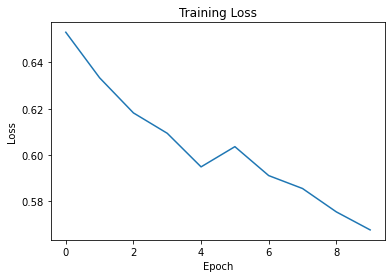

In [19]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

   

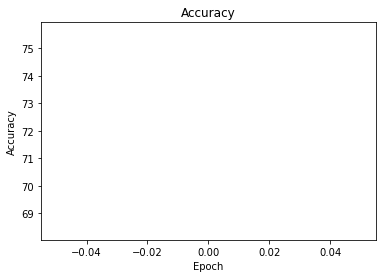

In [21]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Initialize empty lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate F1 score and confusion matrix
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print F1 score and confusion matrix
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

F1 Score: 0.6551
Confusion Matrix:
[[350 254]
 [142 376]]


In [28]:
num_classes=2
model = ModifiedCheXNet(num_classes)
model.to('cpu')

ModifiedCheXNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, m

In [33]:
# Load the saved model state dictionary
model.load_state_dict(torch.load('model1.pth'))

# Set the number of additional epochs
additional_epochs = 5


In [34]:
# Set the starting epoch
start_epoch = num_epochs + 1

In [35]:
avg_losses = []
for epoch in range(start_epoch, start_epoch + additional_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    avg_losses.append(train_loss)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%  and time : {elapsed_time:.2f}')

Epoch 12/10, Train Loss: 0.5533, Accuracy: 72.95%  and time : 1336.30
Epoch 13/10, Train Loss: 0.5584, Accuracy: 72.37%  and time : 1348.64
Epoch 14/10, Train Loss: 0.5543, Accuracy: 73.10%  and time : 1341.94
Epoch 15/10, Train Loss: 0.5561, Accuracy: 73.02%  and time : 1339.22
Epoch 16/10, Train Loss: 0.5578, Accuracy: 72.73%  and time : 1364.30


In [36]:
# Set the path and filename for saving the model
save_path = 'model1_2.pth'

# Save the model
torch.save(model.state_dict(), save_path)